In [139]:
%load_ext autoreload
%autoreload 2

#import cv2
import matplotlib.pyplot as plt
import imageio
import numpy as np
from huggingface_hub import from_pretrained_keras
#from transformers import pipeline
#from PIL import Image, ImageDraw, ImageFont

import sys
sys.path.append("..")
from utils.helpers import extract_filter_and_deskew_textlines, return_scaled_image, do_prediction, write_dict_to_json, load_json_to_dict, perform_ocr_on_textlines, create_text_overlay_image, binarize_image, visualize_model_output#, resize_image, adjust_font_size

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
# GENERAL ARGS - MODIFY!
img_name = 'beschluss'
img_path = '../test_data/' + img_name + '_image.jpg'
binarize_mode = 'detailed' # 'detailed', 'fast', 'no'
min_pixel_sum = 20 # for textline segments filtering
median_bounds = (.5, 20) # for textline segments filtering
font_size = 30 # for generated result image (-1 for dynamic font size)

### Inspect input image

C:\Users\phili\AppData\Local\Temp\ipykernel_17168\2760043657.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


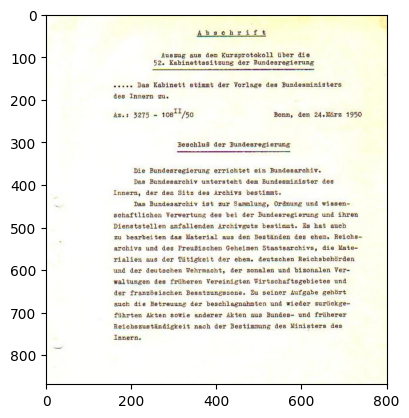

In [148]:
img = imageio.imread(img_path)
plt.imshow(img)

### Binarize image

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 6048.02it/s]


c:\Users\phili\anaconda3\envs\ocrd\lib\site-packages\keras\src\layers\core\lambda_layer.py:327: UserWarning: keras.layers.core is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


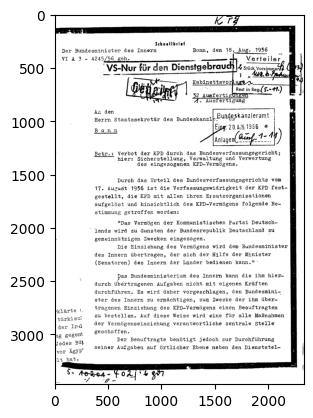

In [4]:
binarized = binarize_image(img, 'detailed')
plt.imshow(binarized)

### Predict textlines segments

In [42]:
model_name = "SBB/eynollah-textline"
model = from_pretrained_keras(model_name)

textline_segments = do_prediction(model, binarized)

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 6003.30it/s]
c:\Users\phili\anaconda3\envs\ocrd\lib\site-packages\keras\src\layers\core\lambda_layer.py:327: UserWarning: keras.layers.core is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


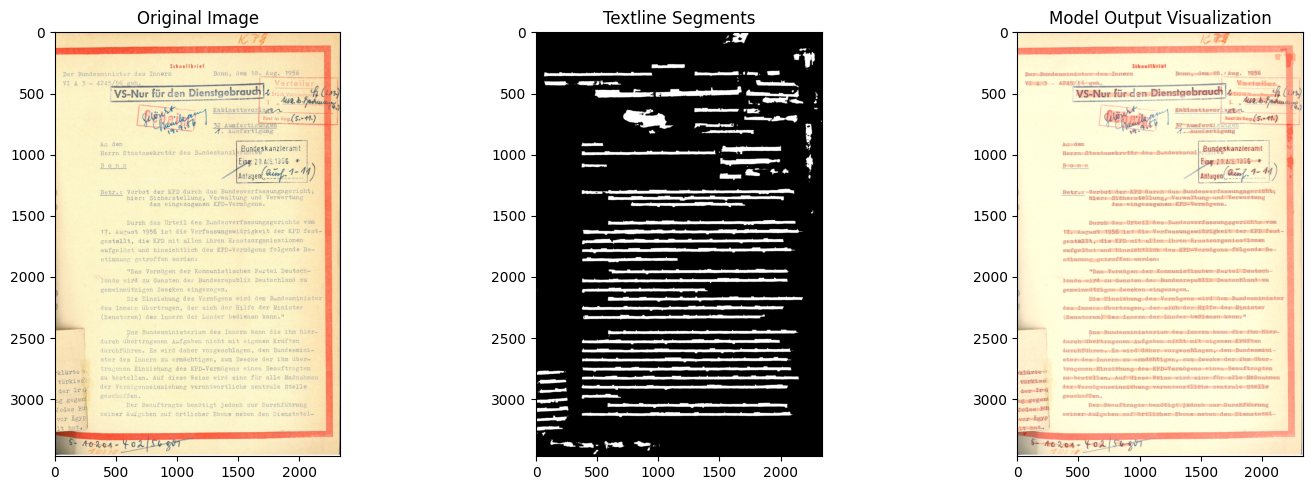

In [125]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # Creates a figure with 3 subplots
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(textline_segments * 255, cmap='gray')
ax[1].set_title('Textline Segments')
ax[2].imshow(visualize_model_output(textline_segments, img))
ax[2].set_title('Model Output Visualization')
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area
plt.show()  # Display the figure

In [12]:
path = '../test_data/' + img_name + '_textlineSegments.png'
imageio.imwrite(path, textline_segments*255)
textline_segments = imageio.imread(path)

C:\Users\phili\AppData\Local\Temp\ipykernel_17168\2324446139.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  textline_segments = imageio.imread('../test_data/kpd_textlineSegments.png')


### Extract text lines from image, then filter them by size and de-skew them

In [135]:
img_resized = return_scaled_image(img, 1, img.shape[1]) # textline_segments where predicted on rescaled image

textline_images, textline_segments_deleted = extract_filter_and_deskew_textlines(img_resized, textline_segments[...,0], min_pixel_sum, median_bounds)

Kept 67 of 264 text segments after size filtering.
Median segment size (pixel sum) used for filtering: 3345.
All segments deleted smaller than 20 pixels (absolute min size).
All segments deleted smaller than 1672.5 pixels (lower median bound).
All segments deleted bigger than 66900.0 pixels (upper median bound).


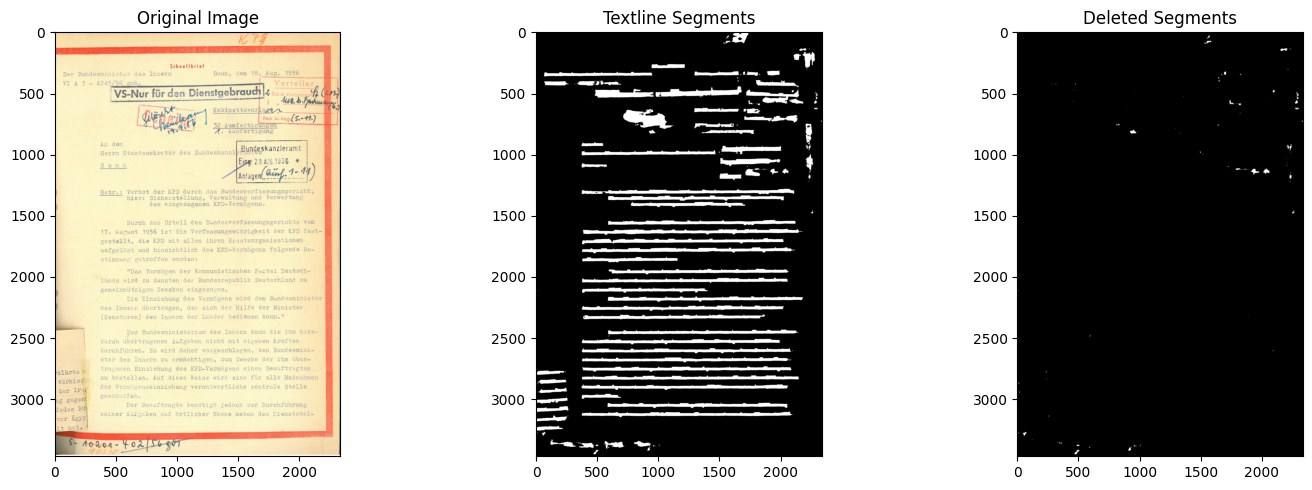

In [136]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # Creates a figure with 3 subplots
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(textline_segments * 255, cmap='gray')
ax[1].set_title('Textline Segments')
ax[2].imshow(textline_segments_deleted*255, cmap='gray')
ax[2].set_title('Deleted Segments')
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area
plt.show()  # Display the figure

### Perform OCR

In [140]:
textline_preds = perform_ocr_on_textlines(textline_images)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
c:\Users\phili\anaconda3\envs\ocrd\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Processing textline no. 1 of 67
Processing textline no. 11 of 67
Processing textline no. 21 of 67
Processing textline no. 31 of 67
Processing textline no. 41 of 67
Processing textline no. 51 of 67
Processing textline no. 61 of 67


In [141]:
path = '../test_data/' + img_name + '_preds.json'
write_dict_to_json(textline_preds, path)
textline_preds = load_json_to_dict(path)

### Print textlines on generated image

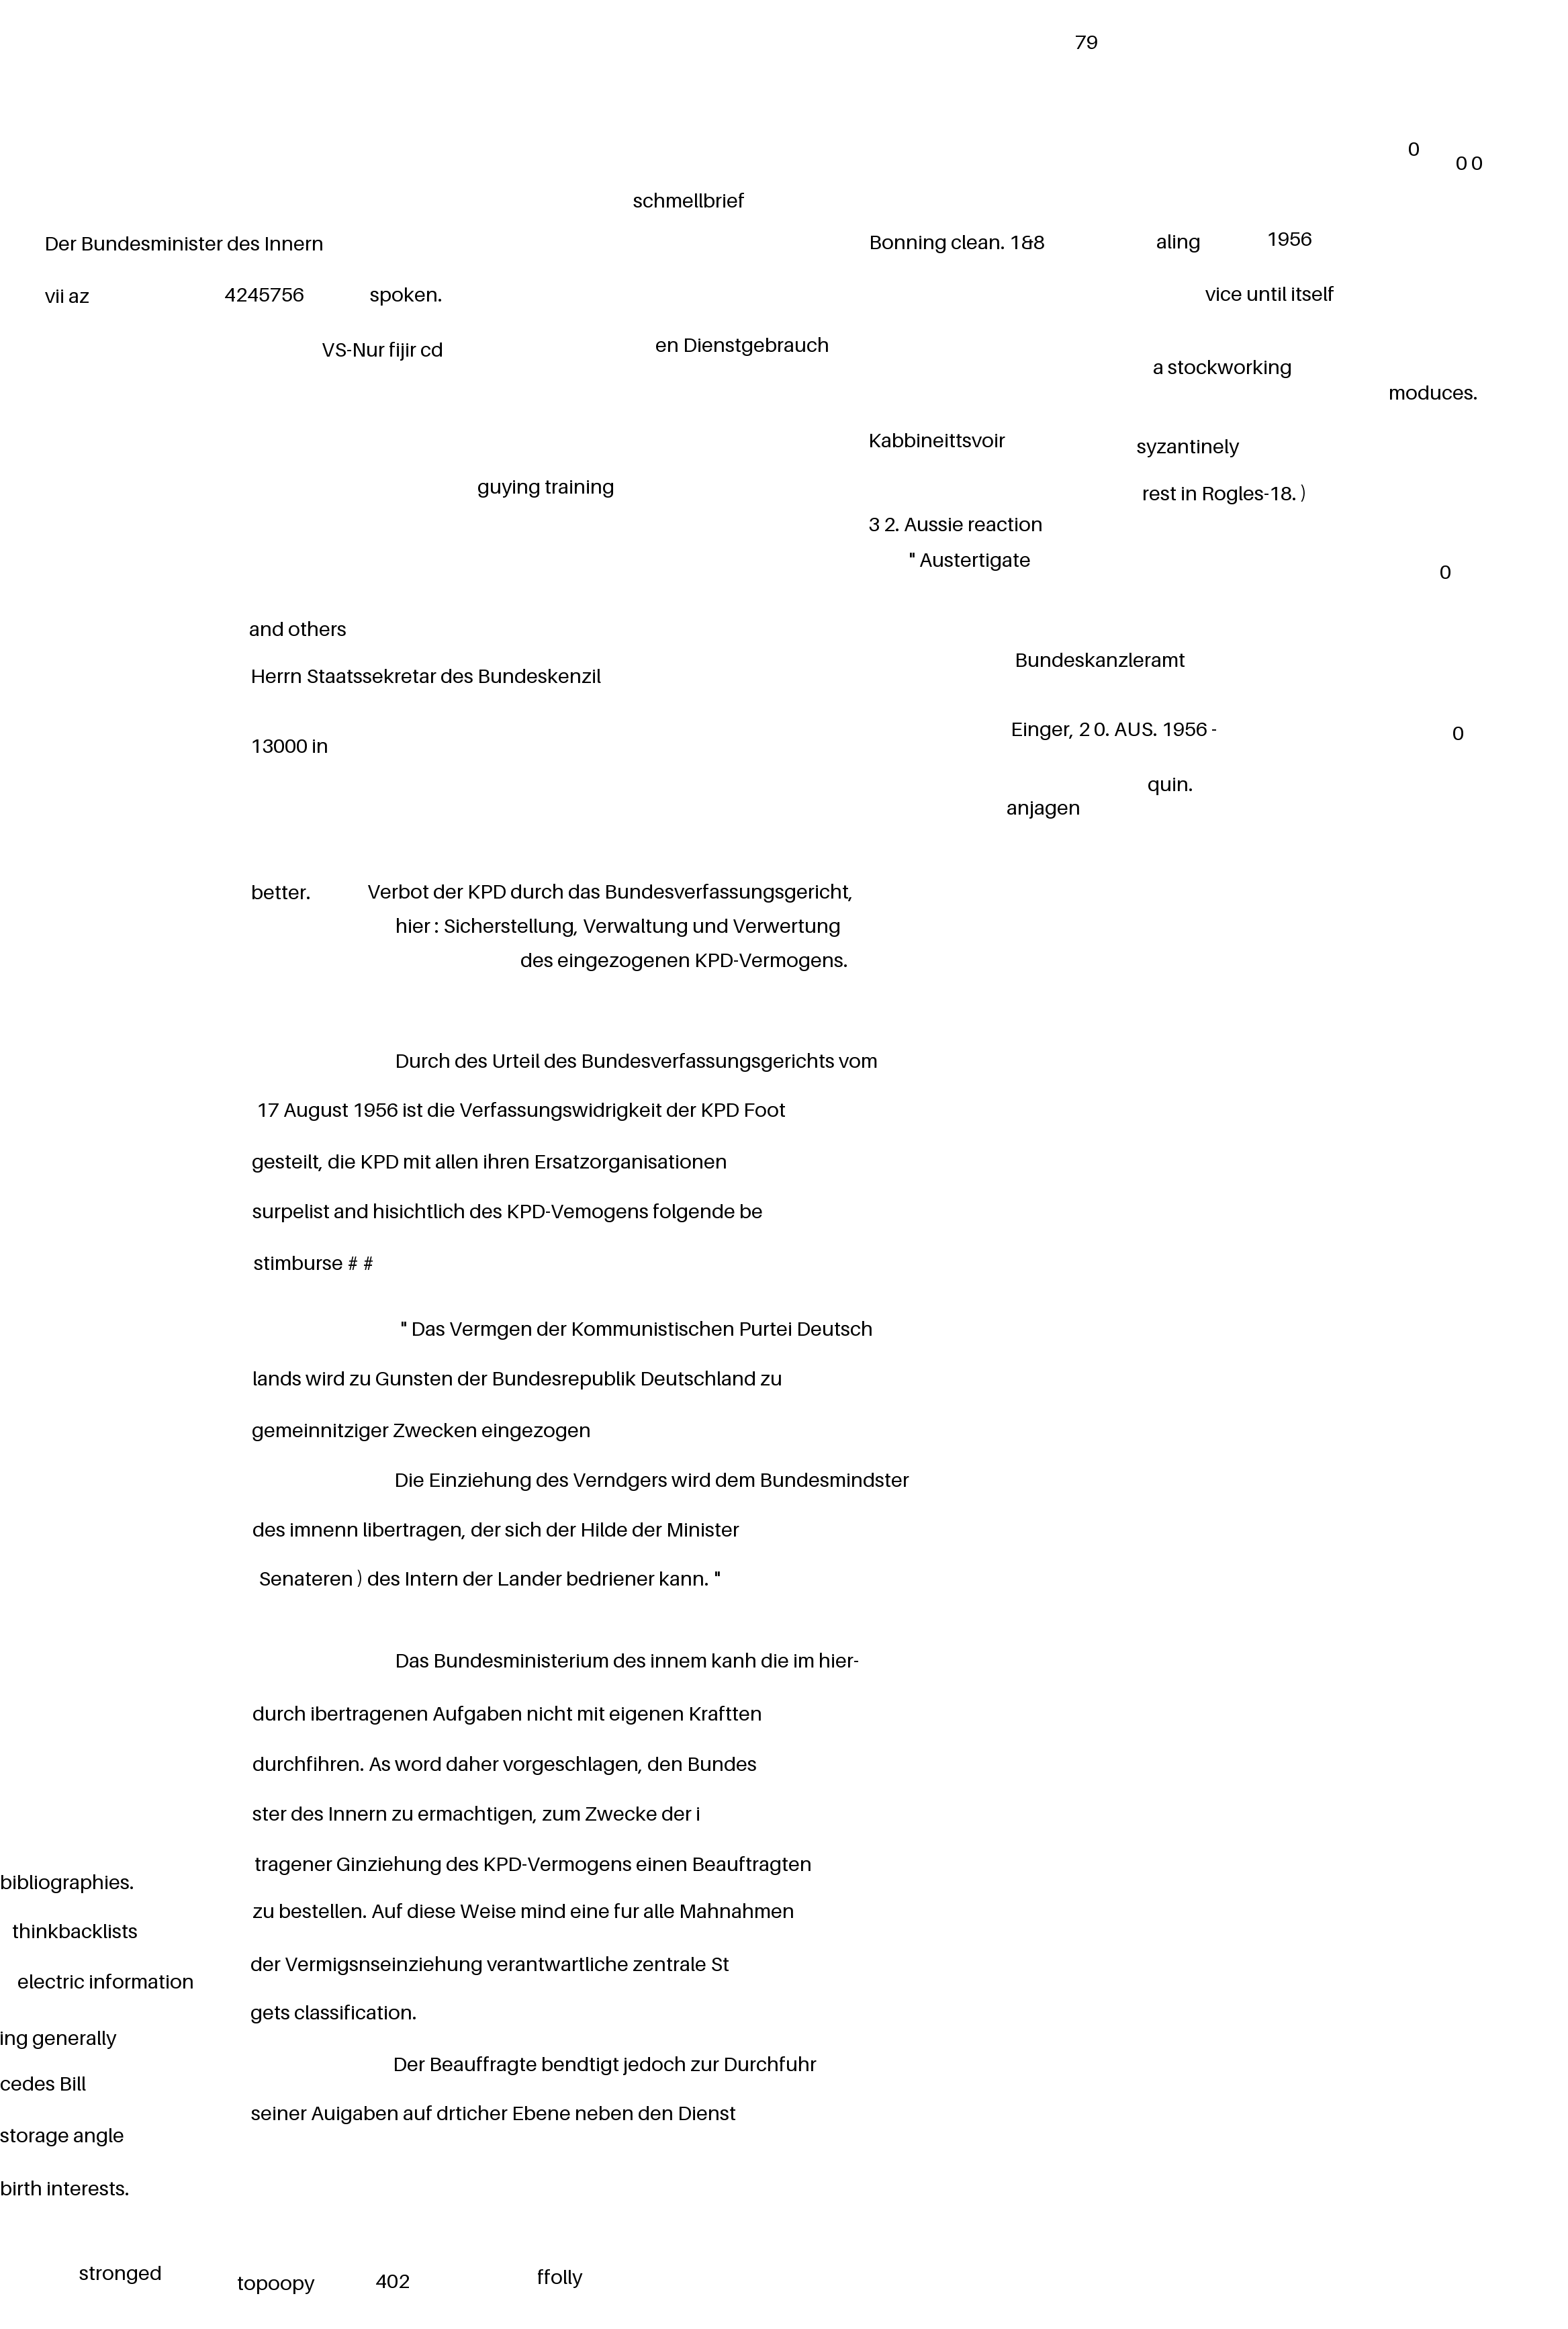

In [146]:
img_gen = create_text_overlay_image(textline_images, textline_preds, (img_resized.shape[0], img_resized.shape[1]), font_size=30)
path = '../test_data/' + img_name + '_imgGen.jpg'
img_gen.save(path)
img_gen

In [33]:
cropped_img = img[1000:1224,1000:1448]
cropped_img = np.expand_dims(cropped_img, 0)

In [29]:
cropped_img = img[:448,:672]
cropped_img = np.expand_dims(cropped_img, 0)

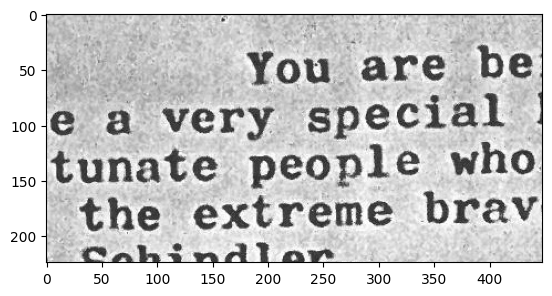

In [34]:
plt.imshow(cropped_img[0])

In [35]:
pred = model.predict(cropped_img/255)

1/1 [==============================] - 0s 353ms/step


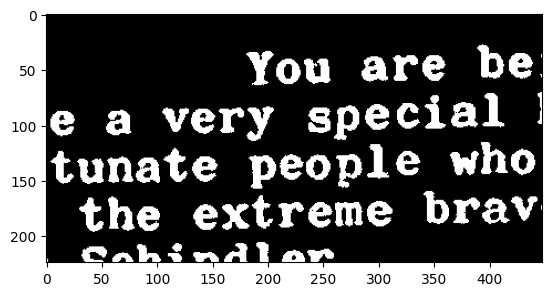

In [37]:
seg = np.argmax(pred, axis=3)[0]
seg_color = np.repeat(seg[:, :, np.newaxis], 3, axis=2)
plt.imshow(seg_color*255)

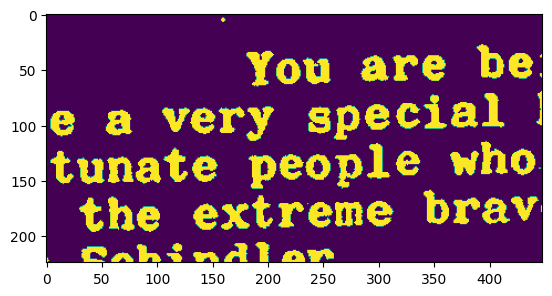

In [36]:
plt.imshow(pred[0,...,1]>.1)

In [41]:
pred = do_line_segmentation(model_name, img)

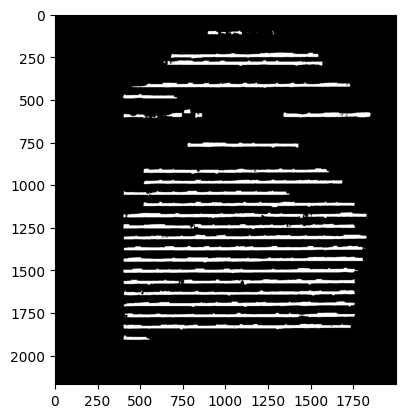

In [36]:
plt.imshow(pred*255)